# Single Leptoquark Analysis

In [1]:
import os
import ROOT
from ROOT import *

Welcome to JupyROOT 6.22/06


In [2]:
class Vector:
    # General vector class: to be used for other particle types.
    ## Retrieval methods
    def GetTLV (self):    
        return self.TLV

    def PT(self):
        # Returns jet transverse momentum
        TLV = self.TLV
        return TLV.Pt()

    def Eta(self):
        # Returns jet pseudorapidity
        TLV = self.TLV
        return TLV.Eta()

    ### Delta methods

    def DeltaR(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaR(TLV2)

    def DeltaEta(self, v2):
        TLV2 = v2.GetTLV()
        return self.Eta() - v2.Eta()

    def DeltaPhi(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaPhi(TLV2)

    def sDeltaPT(self, v2):
        return self.PT() - v2.PT()

    def vDeltaPT(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector2(TLV1.Px(), TLV1.Py())
        b=TVector2(TLV2.Px(), TLV2.Py())
        c=a-b
        return c.Mod()

    def vDeltaP(self,v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector3(TLV1.Px(), TLV1.Py(), TLV1.Pz())
        b=TVector3(TLV2.Px(), TLV2.Py(), TLV2.Pz())
        c=a-b
        return c.Mag()

In [3]:
class JetVector(Vector):
    def __init__(self, event, j):
        self.TLV = TLorentzVector()
        self.TLV.SetPtEtaPhiM(event.GetLeaf('Jet.PT').GetValue(j),
                              event.GetLeaf('Jet.Eta').GetValue(j),
                              event.GetLeaf('Jet.Phi').GetValue(j),
                              event.GetLeaf('Jet.Mass').GetValue(j)
                             )
        self.BTag = event.GetLeaf('Jet.BTag').GetValue(j)
        self.TauTag = event.GetLeaf('Jet.TauTag').GetValue(j)
        self.Charge = event.GetLeaf('Jet.Charge').GetValue(j)
        
    
    ### Retrieval methods
    
    def GetBTag (self):
        return self.BTag
    
    def GetTauTag (self):
        return self.TauTag

In [4]:
class MuonVector(Vector):
    def __init__(self, event, j):
        self.TLV=TLorentzVector()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Muon.PT").GetValue(j), 
            event.GetLeaf("Muon.Eta").GetValue(j), 
            event.GetLeaf("Muon.Phi").GetValue(j), 
            0.1056583755
        )
        self.Charge = event.GetLeaf("Muon.Charge").GetValue(j)

    ### Retrieval methods
    def getCharge(self):
        return self.Charge

In [5]:
class ElectronVector(Vector):
    def __init__(self, event, j):
        self.TLV=TLorentzVector()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Electron.PT").GetValue(j), 
            event.GetLeaf("Electron.Eta").GetValue(j), 
            event.GetLeaf("Electron.Phi").GetValue(j), 
            0.000511
        )
        self.Charge = event.GetLeaf("Electron.Charge").GetValue(j)
    
    ### Retrieval methods
    def getCharge(self):
        return self.Charge

In [6]:
def PT(jet):
    # Returns jet transverse momentum
    return jet.PT()

def getGoodJets(event):
    """
    Separate jet types into a map structure.
    """
    jetDict = {'jets' : [],
                'b_jets' : [],
                'tau_jets' : [],
                'muons' : [],
                'electrons' : [],
                'all_jets' : [],
                'other_jets' : []
               }
    
    n_jets = event.Jet.GetEntries()
    
    for i in range(n_jets):
        jet = JetVector(event, i)
        
        if PT(jet)<= 20.:
            continue
        
        jetDict['all_jets'] += [jet]
        if (jet.GetBTag() == 0 and jet.GetTauTag() == 0):
            if jet.PT()>30.:
                jetDict['jets'] += [jet]
                
        elif (jet.GetBTag() == 1 and jet.GetTauTag() == 0):
            if (jet.PT()>30.) and abs(jet.Eta())<2.5:
                jetDict['b_jets'] += [jet]
        
        elif (jet.GetBTag() == 0 and jet.GetTauTag() == 1):
            if abs(jet.Eta())<2.5:
                jetDict['tau_jets'] += [jet]
        else:
            jetDict['other_jets'] += [jet]

    n_muons = event.Muon.GetEntries()

    for i in range(n_muons):
        muon = MuonVector(event, i)
        
        if PT(muon)>30. and abs(muon.Eta())<2.3:
            jetDict['muons'] += [muon]

    n_electrons = event.Electron.GetEntries()

    for i in range(n_electrons):
        electron = ElectronVector(event, i)

        if PT(electron)>35 and abs(electron.Eta())<2.3:
            jetDict['electrons'] += [electron]
        
            
    # for key in jetDict:
    #     jetDict[key].sort(reverse = True, key = PT)
        
    return jetDict

In [7]:
def getData (fullAnalysis=True):
    """
    Function to read data from Delphes-generated events
    """
    ev_dir = "/disco4/SIMULACIONES/Cristian/Madgraph/Single_vlq_mlq500_2/Events"   # Event directory path
    
    if fullAnalysis:
        root, dirs, files = next(os.walk(ev_dir))
        jobs = len(dirs)
    else:
        jobs = 1
    
    tree = TChain('Delphes;1')
    for i in range(jobs):
        path = str('/run_{:02d}/tag_1_delphes_events.root'.format(i+1))
        tree.Add(ev_dir + path)
        print('Run found in ' + path)
    print('Total events uploaded: {}'.format(tree.GetEntries()))

    return tree

In [8]:
tree = getData()

Run found in /run_01/tag_1_delphes_events.root
Run found in /run_02/tag_1_delphes_events.root
Run found in /run_03/tag_1_delphes_events.root
Run found in /run_04/tag_1_delphes_events.root
Run found in /run_05/tag_1_delphes_events.root
Run found in /run_06/tag_1_delphes_events.root
Run found in /run_07/tag_1_delphes_events.root
Run found in /run_08/tag_1_delphes_events.root
Run found in /run_09/tag_1_delphes_events.root
Run found in /run_10/tag_1_delphes_events.root
Run found in /run_11/tag_1_delphes_events.root
Run found in /run_12/tag_1_delphes_events.root
Run found in /run_13/tag_1_delphes_events.root
Run found in /run_14/tag_1_delphes_events.root
Run found in /run_15/tag_1_delphes_events.root
Run found in /run_16/tag_1_delphes_events.root
Run found in /run_17/tag_1_delphes_events.root
Run found in /run_18/tag_1_delphes_events.root
Run found in /run_19/tag_1_delphes_events.root
Run found in /run_20/tag_1_delphes_events.root
Run found in /run_21/tag_1_delphes_events.root
Run found in 

Warning in <TClass::Init>: no dictionary for class HepMCEvent is available
Warning in <TClass::Init>: no dictionary for class Event is available
Warning in <TClass::Init>: no dictionary for class GenParticle is available
Warning in <TClass::Init>: no dictionary for class SortableObject is available
Warning in <TClass::Init>: no dictionary for class Track is available
Warning in <TClass::Init>: no dictionary for class Tower is available
Warning in <TClass::Init>: no dictionary for class Jet is available
Warning in <TClass::Init>: no dictionary for class MissingET is available
Warning in <TClass::Init>: no dictionary for class Electron is available
Warning in <TClass::Init>: no dictionary for class Photon is available
Warning in <TClass::Init>: no dictionary for class Muon is available
Warning in <TClass::Init>: no dictionary for class ScalarHT is available


In [9]:
canvas = TCanvas("Canvas","",800,600)
canvas.SetGrid()
cutflow = TH1F("Cutflow (muons)","Cutflow; Cut; Events",9,0,9)
hist_njets = TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10)

hist_m_LQ=TH1F("hist_m_LQ", "M_{b+#mu}", 40, 0.0, 2000.0)
hist_pt_LQ=TH1F("hist_pt_LQ", "Pt_{b+#mu}", 40, 0.0, 2000.0)

hist_met=TH1F("hist_met", "MeT", 40, 0.0, 2000.0)
hist_m_LQ_met=TH1F("hist_m_LQ_met", "M_{b+#mu+MET}", 40, 0.0, 2000.0)
hist_pt_LQ_met=TH1F("hist_pt_LQ_met", "Pt_{b+#mu+MET}", 40, 0.0, 2000.0)

pt_all_jets=TH1F("pt_all_jets", "Pt_{allj}", 100, 0.0, 600.0)
eta_all_jets=TH1F("eta_all_jets", "#eta_{allj}", 100, -5, 5)
pt_all_jets.SetLineColor(kBlack)
eta_all_jets.SetLineColor(kBlack)

pt_lead_jets=TH1F("pt_lead_jets", "Pt_{j1}", 100, 0.0, 1000.0)
eta_lead_jets=TH1F("eta_lead_jets", "#eta_{j1}", 100, -5, 5)
pt_lead_jets.SetLineColor(kBlue)
eta_lead_jets.SetLineColor(kBlue)
pt_lead_bjets=TH1F("pt_lead_bjets", "Pt_{bj}", 100, 0.0, 1000.0)
eta_lead_bjets=TH1F("eta_lead_bjets", "#eta_{bj}", 100, -5, 5)
pt_lead_bjets.SetLineColor(kRed)
eta_lead_bjets.SetLineColor(kRed)
pt_taus=TH1F("pt_lead_taus", "Pt_{tau}", 100, 0.0, 1000.0)
eta_taus=TH1F("eta_lead_taus", "#eta_tau", 100, -5, 5)
pt_taus.SetLineColor(kGreen)
eta_taus.SetLineColor(kGreen)
pt_muon=TH1F("pt_electron", "Pt_e", 100, 0.0, 1000.0)
eta_muon=TH1F("eta_electron", "#eta_e", 100, -5, 5)
pt_muon.SetLineColor(kViolet)
eta_muon.SetLineColor(kViolet)

hist_deltar_tau_mu=TH1F("deltar_tau_e","#Delta R_{e#tau}",100,0,8) 
hist_deltar_b_tau=TH1F("deltar_b_tau","#Delta R_{b#tau}",100,0,8) 
hist_deltar_b_mu=TH1F("deltar_b_e","#Delta R_{b#mu}",100,0,8) 
hist_deltar_j_tau=TH1F("deltar_j_tau","#Delta R_{j#tau}",100,0,8) 
hist_deltar_j_mu=TH1F("deltar_j_e","#Delta R_{j#mu}",100,0,8) 
hist_deltar_b_j=TH1F("deltar_b_j","#Delta R_{bj}",100,0,8)

hist_deltaEta_tau_mu=TH1F("deltaEta_tau_e","#Delta #eta_{e #tau}",100,-5,5)
hist_deltaEta_b_tau=TH1F("deltaEta_b_tau","#Delta #eta_{b#tau}",100,-5,5) 
hist_deltaEta_b_mu=TH1F("deltaEta_b_sltau","#Delta #eta_{b#mu}",100,-5,5) 
hist_deltaEta_j_tau=TH1F("deltaEta_j_ltau","#Delta #eta_{j#tau}",100,-5,5) 
hist_deltaEta_j_mu=TH1F("deltaEta_j_e","#Delta #eta_{j#mu}",100,-5,5) 
hist_deltaEta_b_j=TH1F("deltaEta_b_j","#Delta #eta_{bj}",100,-5,5)


hist_deltaPhi_tau_mu=TH1F("deltaPhi_tau_e","#Delta #phi_{e #tau}",100,-5,5)
hist_deltaPhi_b_tau=TH1F("deltaPhi_b_tau","#Delta #phi_{b#tau}",100,-5,5) 
hist_deltaPhi_b_mu=TH1F("deltaPhi_b_sltau","#Delta #phi_{b#mu}",100,-5,5) 
hist_deltaPhi_j_tau=TH1F("deltaPhi_j_ltau","#Delta #phi_{j#tau}",100,-5,5) 
hist_deltaPhi_j_mu=TH1F("deltaPhi_j_sltau","#Delta #phi_{j#mu}",100,-5,5) 
hist_deltaPhi_b_j=TH1F("deltaPhi_b_j","#Delta #phi_{bj}",100,-5,5)

hist_sdPT_tau_mu=TH1F("sdPT_tau_e","#Delta PT_{e #tau}",100,0,1000)
hist_sdPT_b_tau=TH1F("sdPT_b_tau","#Delta PT_{b#tau}",100,-800,800) 
hist_sdPT_b_mu=TH1F("sdPT_b_sltau","#Delta PT_{b#mu}",100,-800,800) 
hist_sdPT_j_tau=TH1F("sdPT_j_ltau","#Delta PT_{j#tau}",100,-800,800) 
hist_sdPT_j_mu=TH1F("sdPT_j_sltau","#Delta PT_{j#mu}",100,-800,800) 
hist_sdPT_b_j=TH1F("sdPT_b_j","#Delta PT_{bj}",100,-800,800)

hist_vdPT_tau_mu=TH1F("vdPT_tau_e","#Delta #vec{PT}_{e #tau}",100,0,1000)
hist_vdPT_b_tau=TH1F("vdPT_b_tau","#Delta #vec{PT}_{b#tau}",100,0,800) 
hist_vdPT_b_mu=TH1F("vdPT_b_sltau","#Delta #vec{PT}_{b#mu}",100,0,800) 
hist_vdPT_j_tau=TH1F("vdPT_j_ltau","#Delta #vec{PT}_{j#tau}",100,0,800) 
hist_vdPT_j_mu=TH1F("vdPT_j_sltau","#Delta #vec{PT}_{j#mu}",100,0,800) 
hist_vdPT_b_j=TH1F("vdPT_b_j","#Delta #vec{PT}_{bj}",100,0,800)

hist_vdP_tau_mu=TH1F("vdP_tau_e","#Delta #vec{P}_{e #tau}",100,0,1000)
hist_vdP_b_tau=TH1F("vdP_b_tau","#Delta #vec{P}_{b#tau}",100,0,800) 
hist_vdP_b_mu=TH1F("vdP_b_sltau","#Delta #vec{P}_{b#mu}",100,0,800) 
hist_vdP_j_tau=TH1F("vdP_j_ltau","#Delta #vec{P}_{j#tau}",100,0,800) 
hist_vdP_j_mu=TH1F("vdP_j_sltau","#Delta #vec{P}_{j#mu}",100,0,800) 
hist_vdP_b_j=TH1F("vdP_b_j","#Delta #vec{P}_{bj}",100,0,800)

pt_forward_jets=TH1F("pt_forward_jets", "Pt_{fj}", 100, 0.0, 600.0)
pt_central_jets=TH1F("pt_central_jets", "Pt_{cj}", 100, 0.0, 600.0)

In [10]:
def FillHistos(jetDict):
    JD = jetDict
    pt_lead_jets.Fill  (JD['jets'][0].PT() )
    eta_lead_jets.Fill (JD['jets'][0].Eta())
    pt_lead_bjets.Fill (JD['b_jets'][0].PT() )
    eta_lead_bjets.Fill(JD['b_jets'][0].Eta())
    pt_taus.Fill  (JD['tau_jets'][0].PT() )
    eta_taus.Fill (JD['tau_jets'][0].Eta())
    pt_muon.Fill (JD['muons'][0].PT() )
    eta_muon.Fill(jetDict['muons'][0].Eta())
    
    pt_all_jets.Fill (JD['b_jets'][0].PT() )
    eta_all_jets.Fill(JD['b_jets'][0].Eta())
    pt_all_jets.Fill (JD['tau_jets'][0].PT()  )
    eta_all_jets.Fill(JD['tau_jets'][0].Eta() )
    pt_all_jets.Fill (JD['muons'][0].PT()  )
    eta_all_jets.Fill(JD['muons'][0].Eta() )

    pt_all_jets.Fill (JD['jets'][0].PT() )
    eta_all_jets.Fill(JD['jets'][0].Eta())


    hist_deltar_tau_mu.Fill(JD['tau_jets'][0].DeltaR(JD['muons'][0]))
    hist_deltar_b_tau.Fill(JD['b_jets'][0].DeltaR(JD['tau_jets'][0]))
    hist_deltar_b_mu.Fill(JD['b_jets'][0].DeltaR(JD['muons'][0]))
    hist_deltar_j_tau.Fill(JD['jets'][0].DeltaR(JD['tau_jets'][0]))
    hist_deltar_j_mu.Fill(JD['jets'][0].DeltaR(JD['muons'][0]))
    hist_deltar_b_j.Fill(JD['b_jets'][0].DeltaR(JD['jets'][0]))

    hist_deltaEta_tau_mu.Fill(JD['tau_jets'][0].DeltaEta(JD['muons'][0]))
    hist_deltaEta_b_tau.Fill(JD['b_jets'][0].DeltaEta(JD['tau_jets'][0]))
    hist_deltaEta_b_mu.Fill(JD['b_jets'][0].DeltaEta(JD['muons'][0]))
    hist_deltaEta_j_tau.Fill(JD['jets'][0].DeltaEta(JD['tau_jets'][0]))
    hist_deltaEta_j_mu.Fill(JD['jets'][0].DeltaEta(JD['muons'][0]))
    hist_deltaEta_b_j.Fill(JD['b_jets'][0].DeltaEta(JD['jets'][0]))

    hist_deltaPhi_tau_mu.Fill(JD['tau_jets'][0].DeltaPhi(JD['muons'][0]))
    hist_deltaPhi_b_tau.Fill(JD['b_jets'][0].DeltaPhi(JD['tau_jets'][0]))
    hist_deltaPhi_b_mu.Fill(JD['b_jets'][0].DeltaPhi(JD['muons'][0]))
    hist_deltaPhi_j_tau.Fill(JD['jets'][0].DeltaPhi(JD['tau_jets'][0]))
    hist_deltaPhi_j_mu.Fill(JD['jets'][0].DeltaPhi(JD['muons'][0]))
    hist_deltaPhi_b_j.Fill(JD['b_jets'][0].DeltaPhi(JD['jets'][0]))

    hist_sdPT_tau_mu.Fill(JD['tau_jets'][0].sDeltaPT(JD['muons'][0]))
    hist_sdPT_b_tau.Fill(JD['b_jets'][0].sDeltaPT(JD['tau_jets'][0]))
    hist_sdPT_b_mu.Fill(JD['b_jets'][0].sDeltaPT(JD['muons'][0]))
    hist_sdPT_j_tau.Fill(JD['jets'][0].sDeltaPT(JD['tau_jets'][0]))
    hist_sdPT_j_mu.Fill(JD['jets'][0].sDeltaPT(JD['muons'][0]))
    hist_sdPT_b_j.Fill(JD['b_jets'][0].sDeltaPT(JD['jets'][0]))

    hist_vdPT_tau_mu.Fill(JD['tau_jets'][0].vDeltaPT(JD['muons'][0]))
    hist_vdPT_b_tau.Fill(JD['b_jets'][0].vDeltaPT(JD['tau_jets'][0]))
    hist_vdPT_b_mu.Fill(JD['b_jets'][0].vDeltaPT(JD['muons'][0]))
    hist_vdPT_j_tau.Fill(JD['jets'][0].vDeltaPT(JD['tau_jets'][0]))
    hist_vdPT_j_mu.Fill(JD['jets'][0].vDeltaPT(JD['muons'][0]))
    hist_vdPT_b_j.Fill(JD['b_jets'][0].vDeltaPT(JD['jets'][0]))

    hist_vdP_tau_mu.Fill(JD['tau_jets'][0].vDeltaP(JD['muons'][0]))
    hist_vdP_b_tau.Fill(JD['b_jets'][0].vDeltaP(JD['tau_jets'][0]))
    hist_vdP_b_mu.Fill(JD['b_jets'][0].vDeltaP(JD['muons'][0]))
    hist_vdP_j_tau.Fill(JD['jets'][0].vDeltaP(JD['tau_jets'][0]))
    hist_vdP_j_mu.Fill(JD['jets'][0].vDeltaP(JD['muons'][0]))
    hist_vdP_b_j.Fill(JD['b_jets'][0].vDeltaP(JD['jets'][0]))
    
    P=jetDict['b_jets'][0].TLV + jetDict['muons'][0].TLV
    hist_m_LQ.Fill(TMath.Sqrt(P*P))

In [11]:
import sys
import time
from etaprogress.progress import ProgressBar
nEvents=tree.GetEntries()

bar = ProgressBar(nEvents, max_width=60)

In [12]:
printEachPercent=12.5
bar.numerator = 0
print(bar)
nSplits=int(100/printEachPercent)

for event in tree:
    
    bar.numerator+=1
    i=bar.numerator
    if int(nSplits*i/nEvents)!=int(nSplits*(i-1)/nEvents):
        print(bar)
    
    n_jets=event.Jet.GetEntries()
    hist_njets.Fill(n_jets)
    cutflow.Fill(0)
    
    if not (n_jets>2): continue

    cutflow.Fill(1)
    
    JD = getGoodJets(event)
    
    if not (len(JD['tau_jets'])==1): continue
    cutflow.Fill(2)
 
    if not (len(JD['b_jets'])==1): continue
    cutflow.Fill(3)
    
    if not (len(JD['jets'])==1): continue
    cutflow.Fill(4)

    if not (len(JD['muons'])==1): continue
    cutflow.Fill(5)

    if not (len(JD['electrons'])==0): continue
    cutflow.Fill(6)

    if not (JD['muons'][0].Charge)*(JD['tau_jets'][0].Charge)<0: continue
    cutflow.Fill(7)

    if not (JD['muons'][0].Charge)*(JD['b_jets'][0].Charge)<0: continue
    cutflow.Fill(8)

    
    FillHistos(JD)

    LQ=JD['b_jets'][0].TLV + JD['muons'][0].TLV
    hist_m_LQ.Fill(LQ.M())
    hist_pt_LQ.Fill(LQ.Pt())

    met=event.GetLeaf("MissingET.MET").GetValue()
    met_phi=event.GetLeaf("MissingET.Phi").GetValue()
    met_eta=event.GetLeaf("MissingET.Eta").GetValue()

    metTLV=TLorentzVector()
    metTLV.SetPtEtaPhiE(met,met_eta,met_phi,met)
    hist_met.Fill(metTLV.Pt())

    LQ += metTLV
    hist_m_LQ_met.Fill(LQ.M())
    hist_pt_LQ_met.Fill(LQ.Pt())
    
    if TMath.Abs(JD['jets'][0].Eta()>=2.5):
        pt_forward_jets.Fill(JD['jets'][0].PT())
    else:
        pt_central_jets.Fill(JD['jets'][0].PT())

  0% (     0/550000) [                         ] eta --:-- /
 12% ( 68750/550000) [###                      ] eta 08:39 -
 25% (137500/550000) [######                   ] eta 07:31 \
 37% (206250/550000) [#########                ] eta 06:15 |
 50% (275000/550000) [############             ] eta 04:48 /
 62% (343750/550000) [###############          ] eta 03:55 -
 75% (412500/550000) [##################       ] eta 02:42 \
 87% (481250/550000) [#####################    ] eta 01:11 |
100% (550000/550000) [#########################] eta 00:01 /


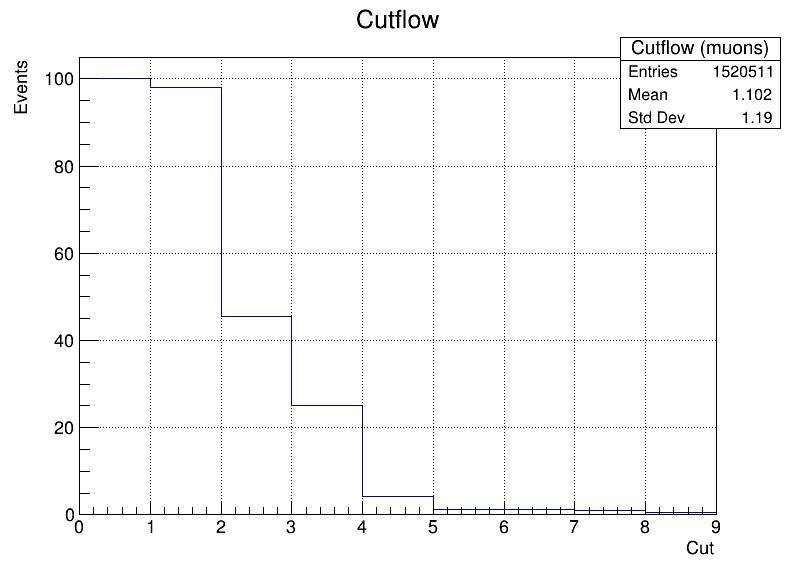

In [13]:
cutflow.Scale(100./nEvents)
cutflow.Draw("hist")
canvas.Draw()

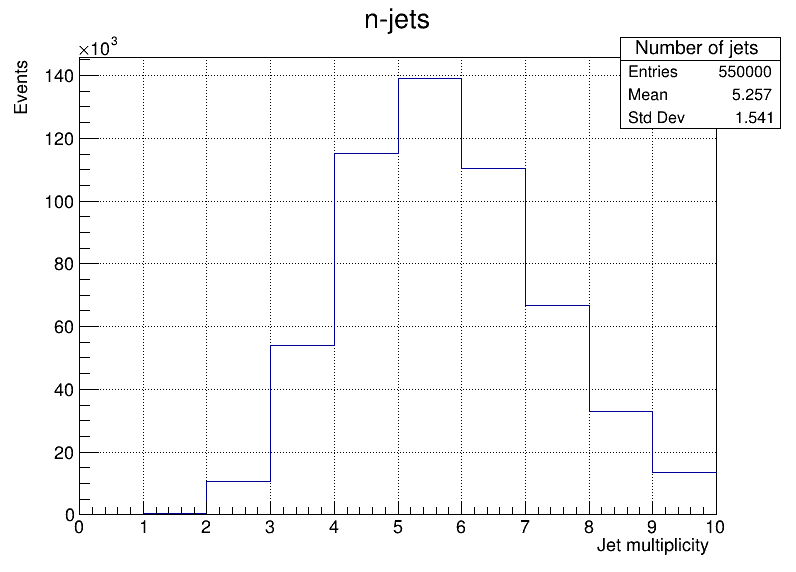

In [14]:
hist_njets.Draw()
canvas.Draw()

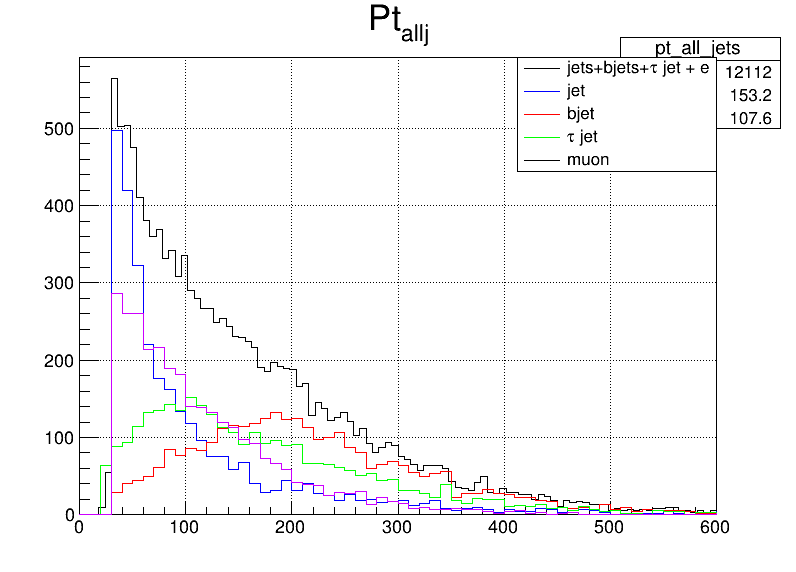

In [15]:
pt_all_jets.Draw("HIST")
pt_lead_jets.Draw("histsame")
pt_lead_bjets.Draw("histsame")
pt_taus.Draw("histsame")
pt_muon.Draw("histsame")

leg=ROOT.TLegend(0.9,0.9,0.65,0.70)
leg.AddEntry("pt_all_jets", "jets+bjets+#tau jet + e", "l")
leg.AddEntry("pt_lead_jets", "jet", "l")
leg.AddEntry("pt_lead_bjets", "bjet", "l")
leg.AddEntry("pt_lead_taus", "#tau jet", "l")
leg.AddEntry("pt_muon", "muon", "l")
leg.Draw()

canvas.Draw()

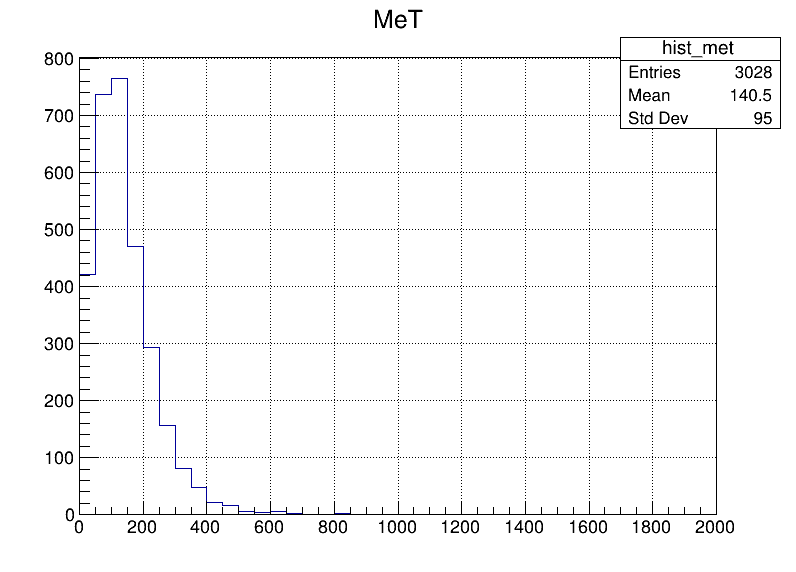

In [16]:
hist_met.Draw()
canvas.Draw() 

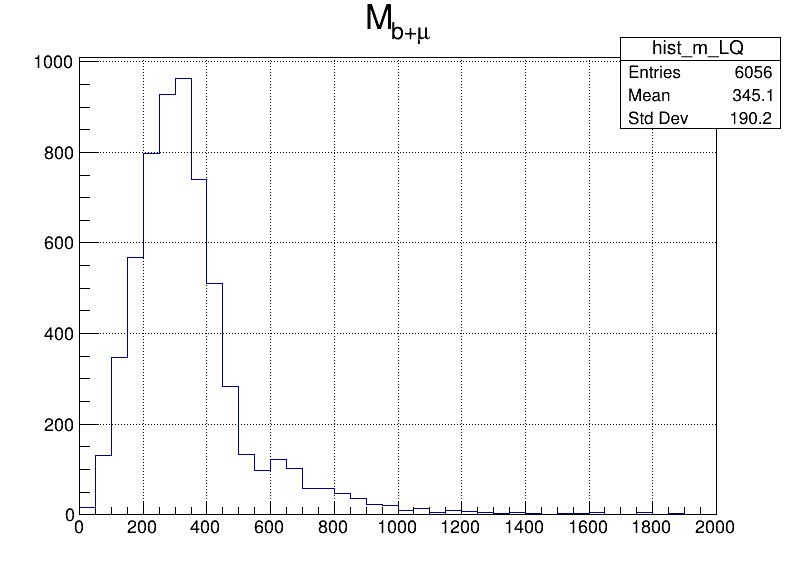

In [17]:
hist_m_LQ.Draw()
canvas.Draw() 

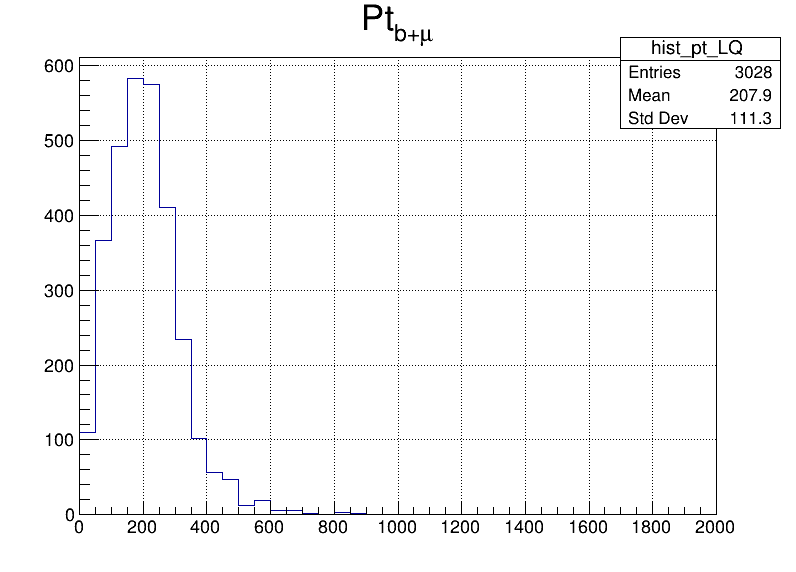

In [18]:
hist_pt_LQ.Draw()
canvas.Draw() 

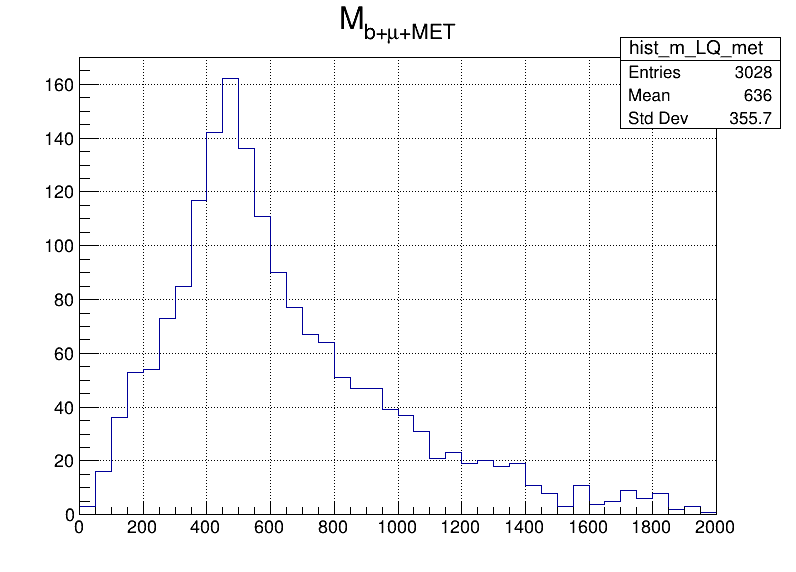

In [19]:
hist_m_LQ_met.Draw()
canvas.Draw() 

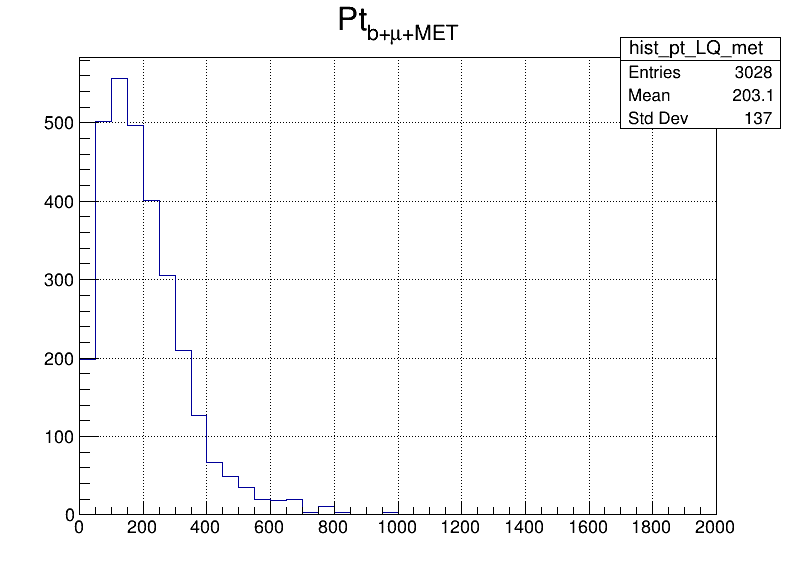

In [20]:
hist_pt_LQ_met.Draw()
canvas.Draw() 

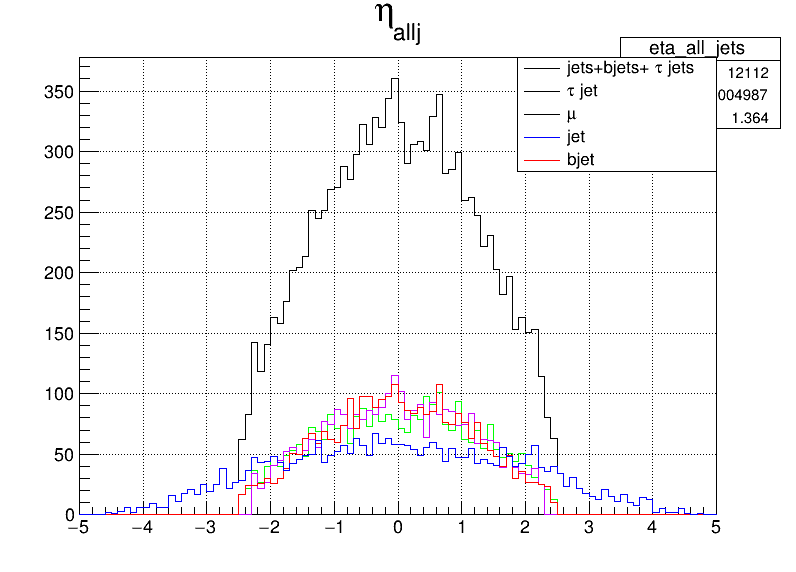

In [21]:
eta_all_jets.Draw("HIST")
eta_taus.Draw("histsame")
eta_muon.Draw("histsame")
eta_lead_bjets.Draw("histsame")
eta_lead_jets.Draw("histsame")
leg=ROOT.TLegend(0.9,0.9,0.65,0.70)
leg.AddEntry("eta_all_jets", "jets+bjets+#tau jets", "l")
leg.AddEntry("eta_taus", "#tau jet", "l")
leg.AddEntry("eta_muon", "#mu", "l")
leg.AddEntry("eta_lead_jets", "jet", "l")
leg.AddEntry("eta_lead_bjets", "bjet", "l")
leg.Draw()
canvas.Draw()

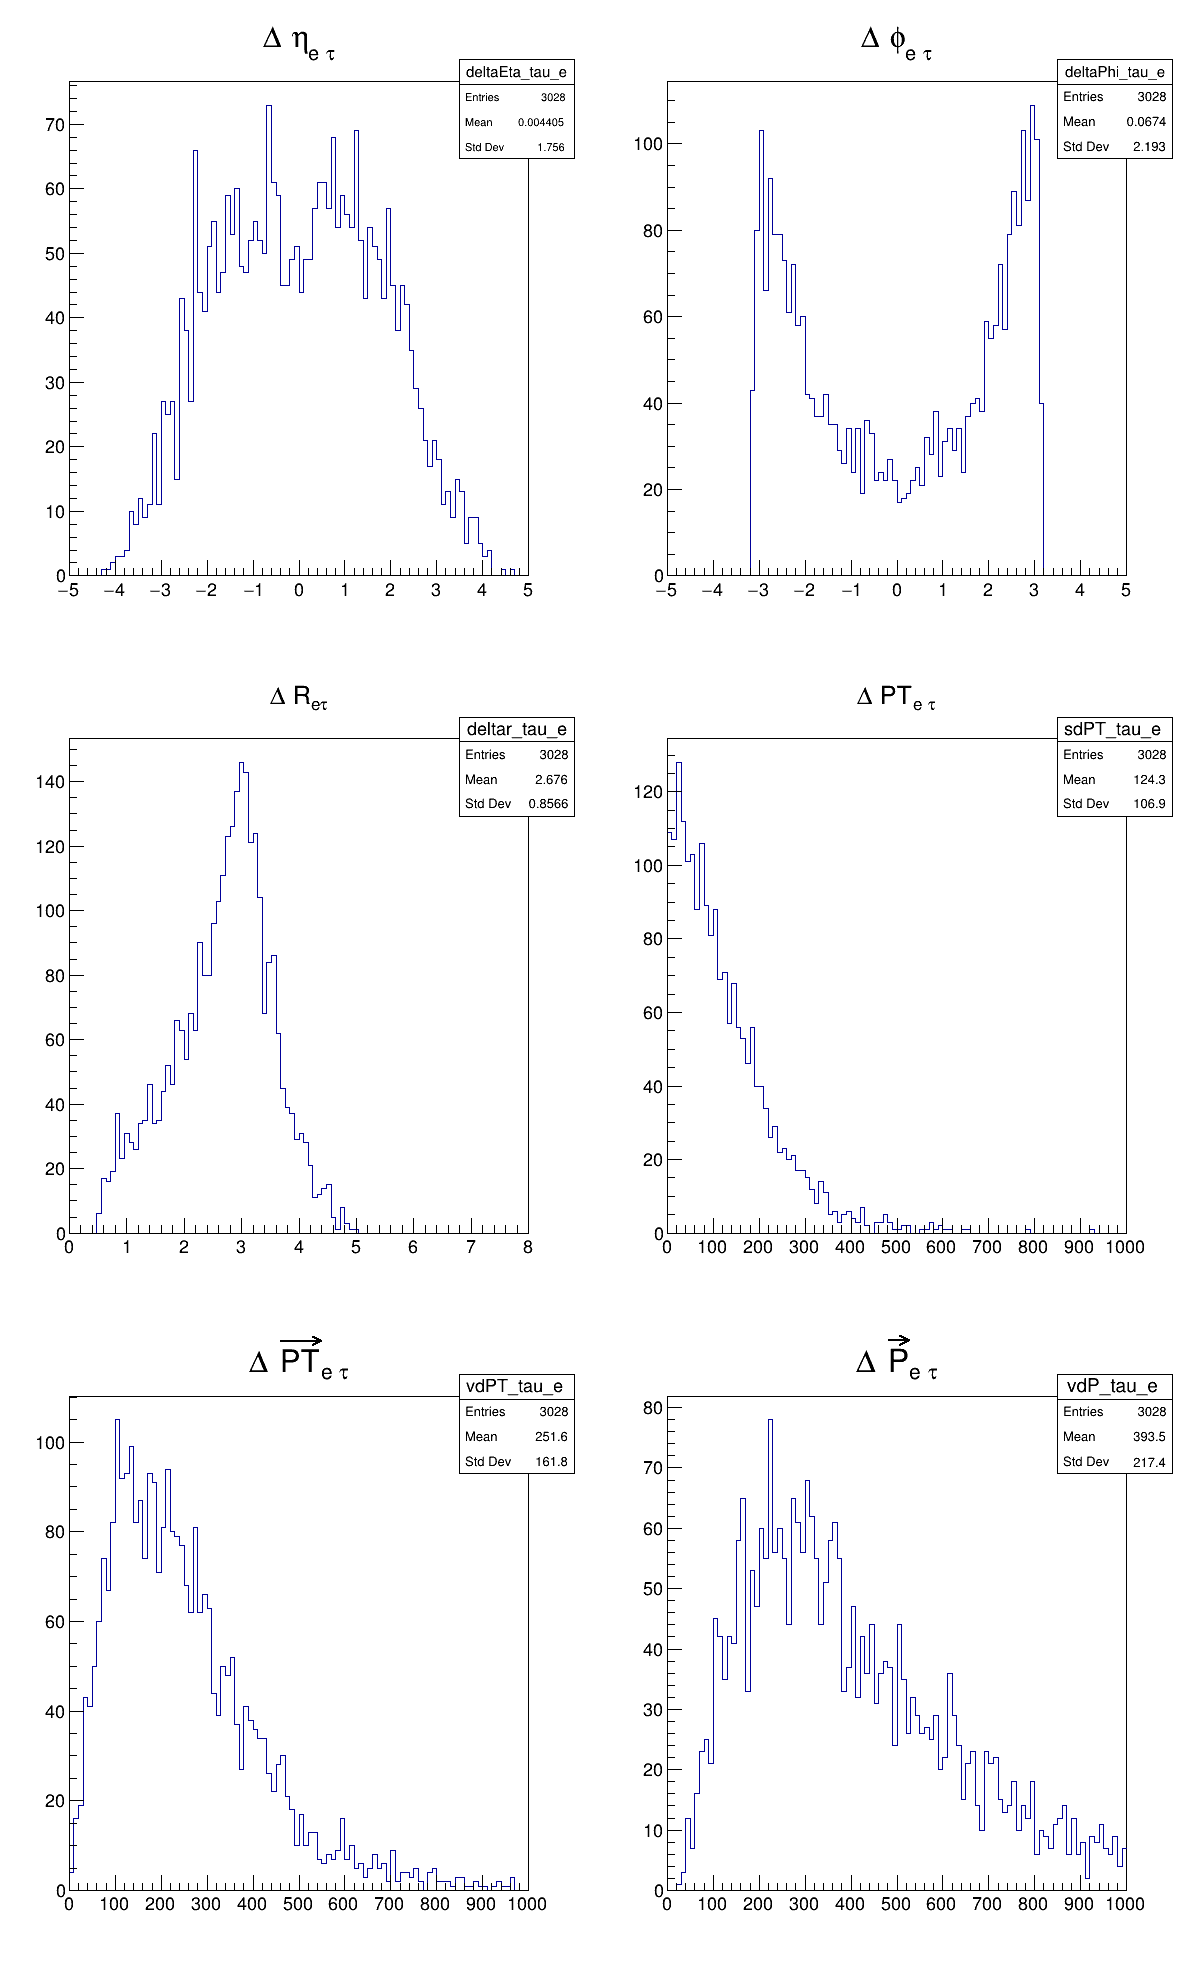

In [22]:
scanvas = TCanvas("SCanvas","",1200,2000)
scanvas.Divide(2,3)
scanvas.cd(1)
hist_deltaEta_tau_mu.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_tau_mu.Draw("hist")
scanvas.cd(3)
hist_deltar_tau_mu.Draw("hist")
scanvas.cd(4)
hist_sdPT_tau_mu.Draw("hist")
scanvas.cd(5)
hist_vdPT_tau_mu.Draw("hist")
scanvas.cd(6)
hist_vdP_tau_mu.Draw("hist")
scanvas.Draw()

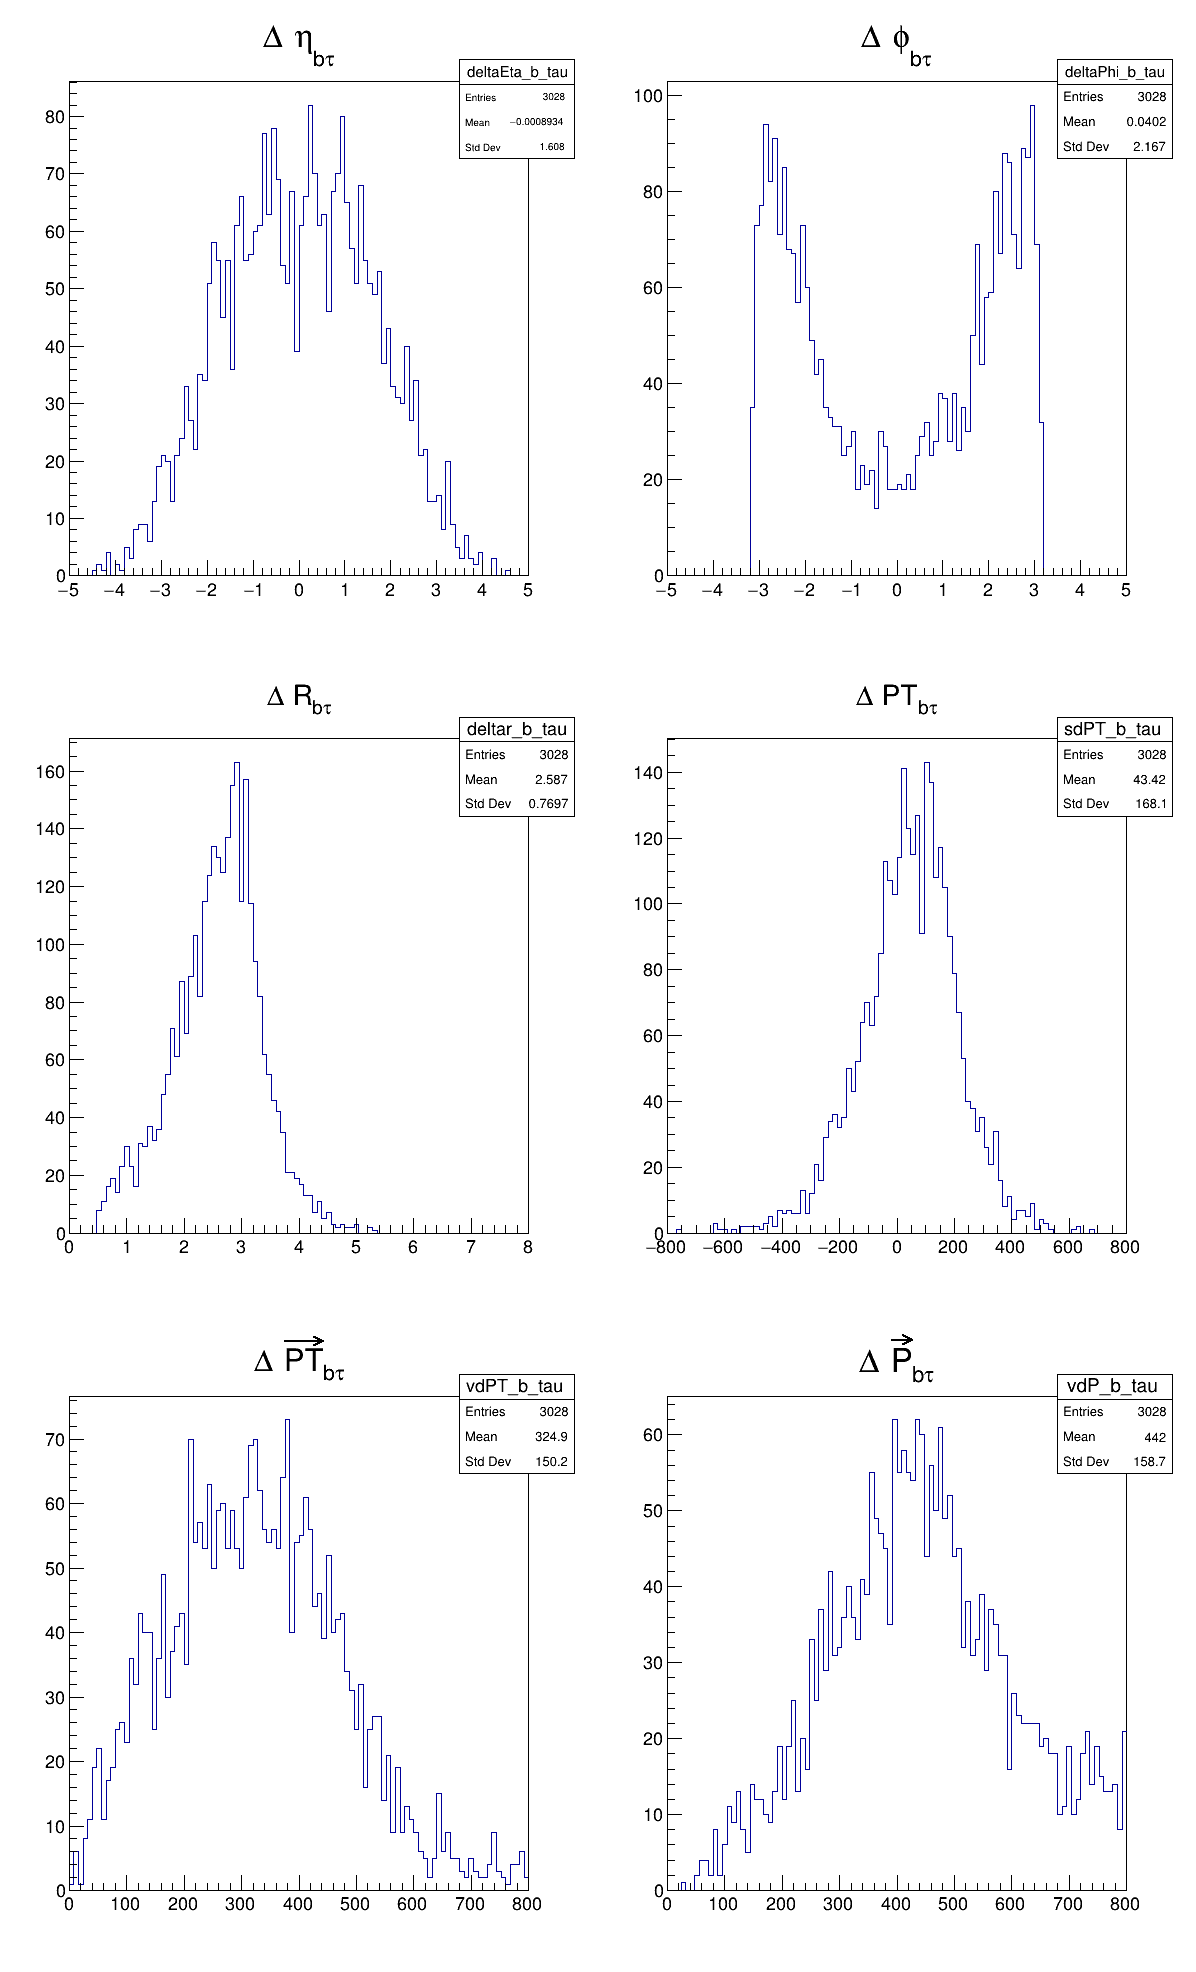

In [23]:
scanvas.cd(1)
hist_deltaEta_b_tau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_tau.Draw("hist")
scanvas.cd(3)
hist_deltar_b_tau.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_tau.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_tau.Draw("hist")
scanvas.cd(6)
hist_vdP_b_tau.Draw("hist")
scanvas.Draw()

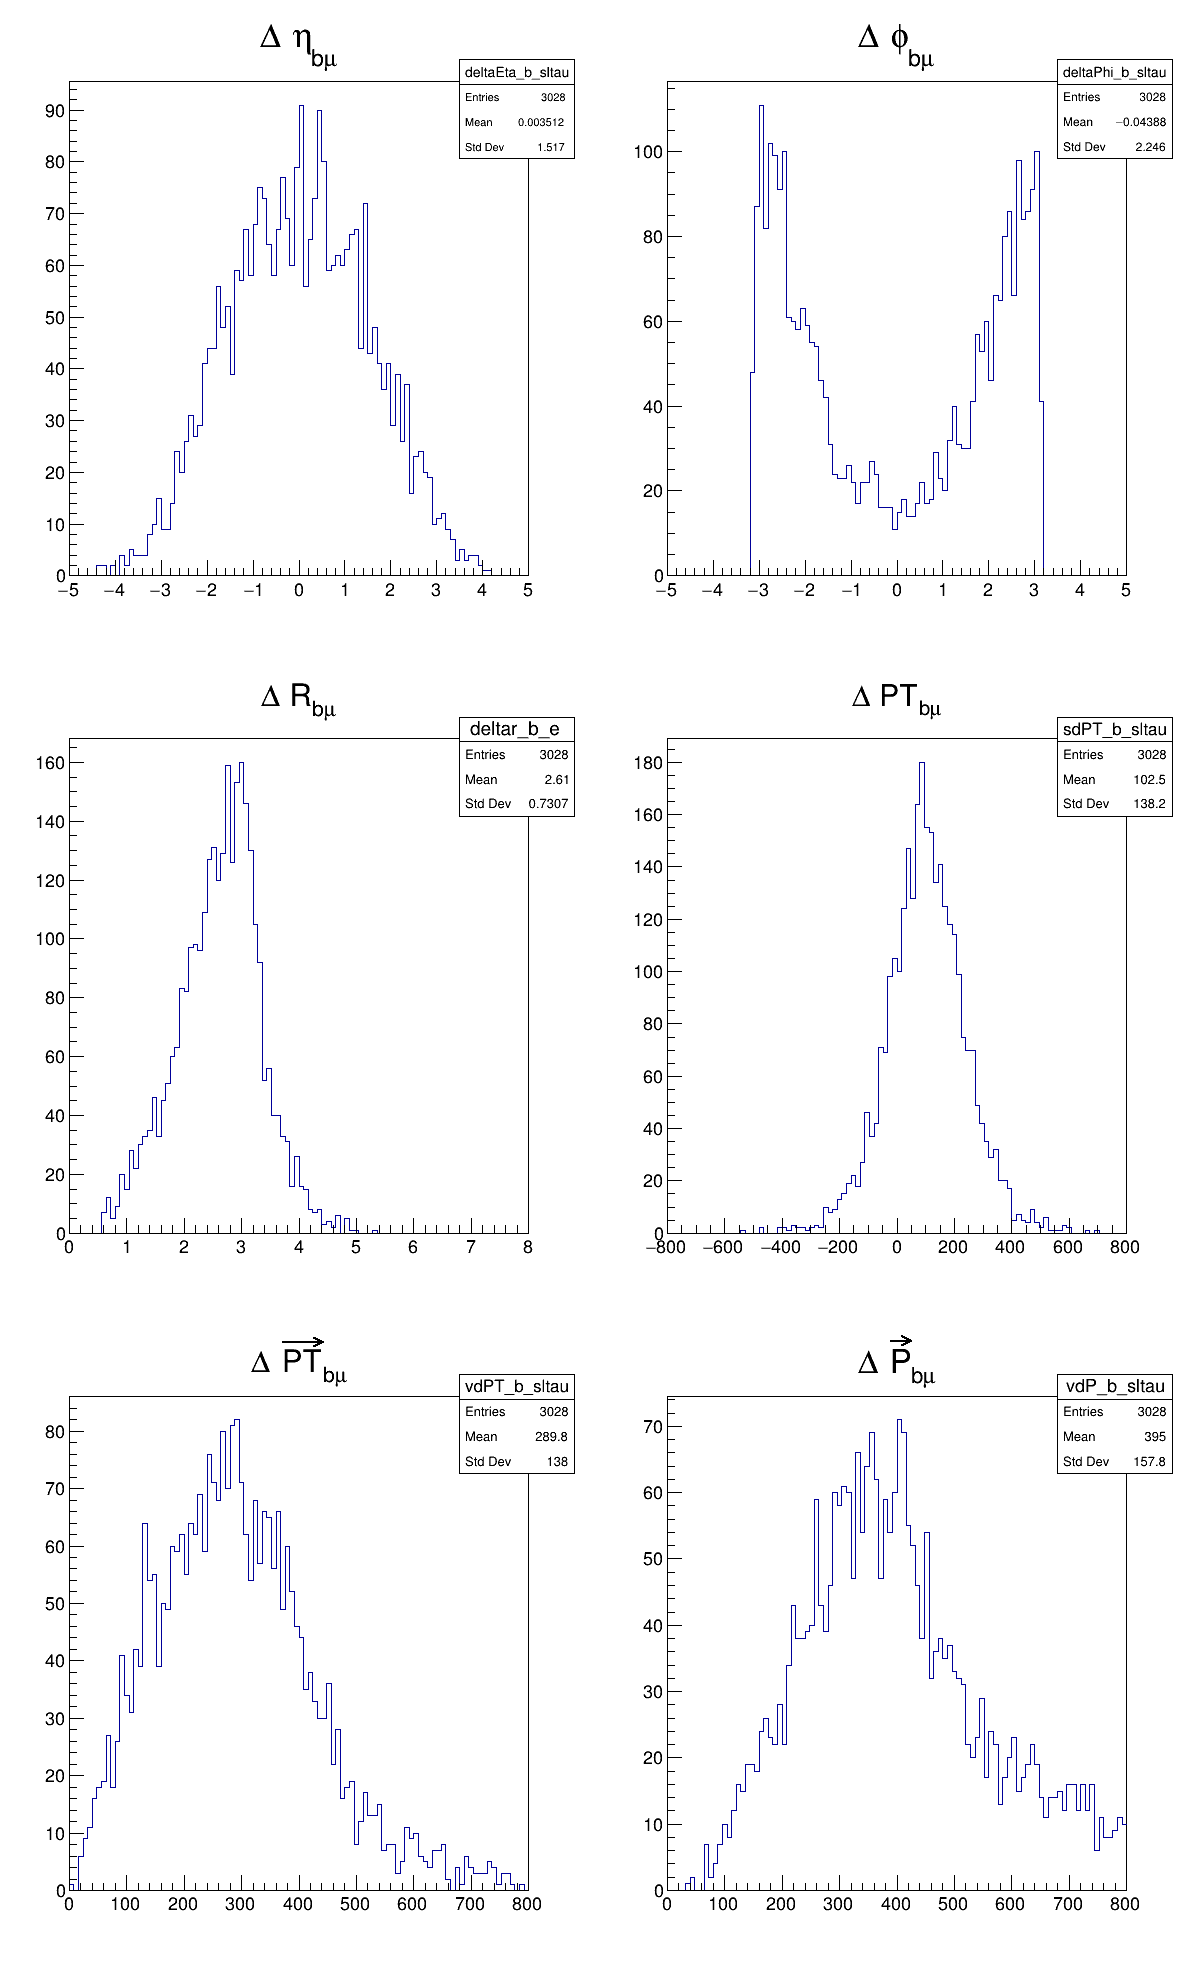

In [24]:
scanvas.cd(1)
hist_deltaEta_b_mu.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_mu.Draw("hist")
scanvas.cd(3)
hist_deltar_b_mu.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_mu.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_mu.Draw("hist")
scanvas.cd(6)
hist_vdP_b_mu.Draw("hist")
scanvas.Draw()

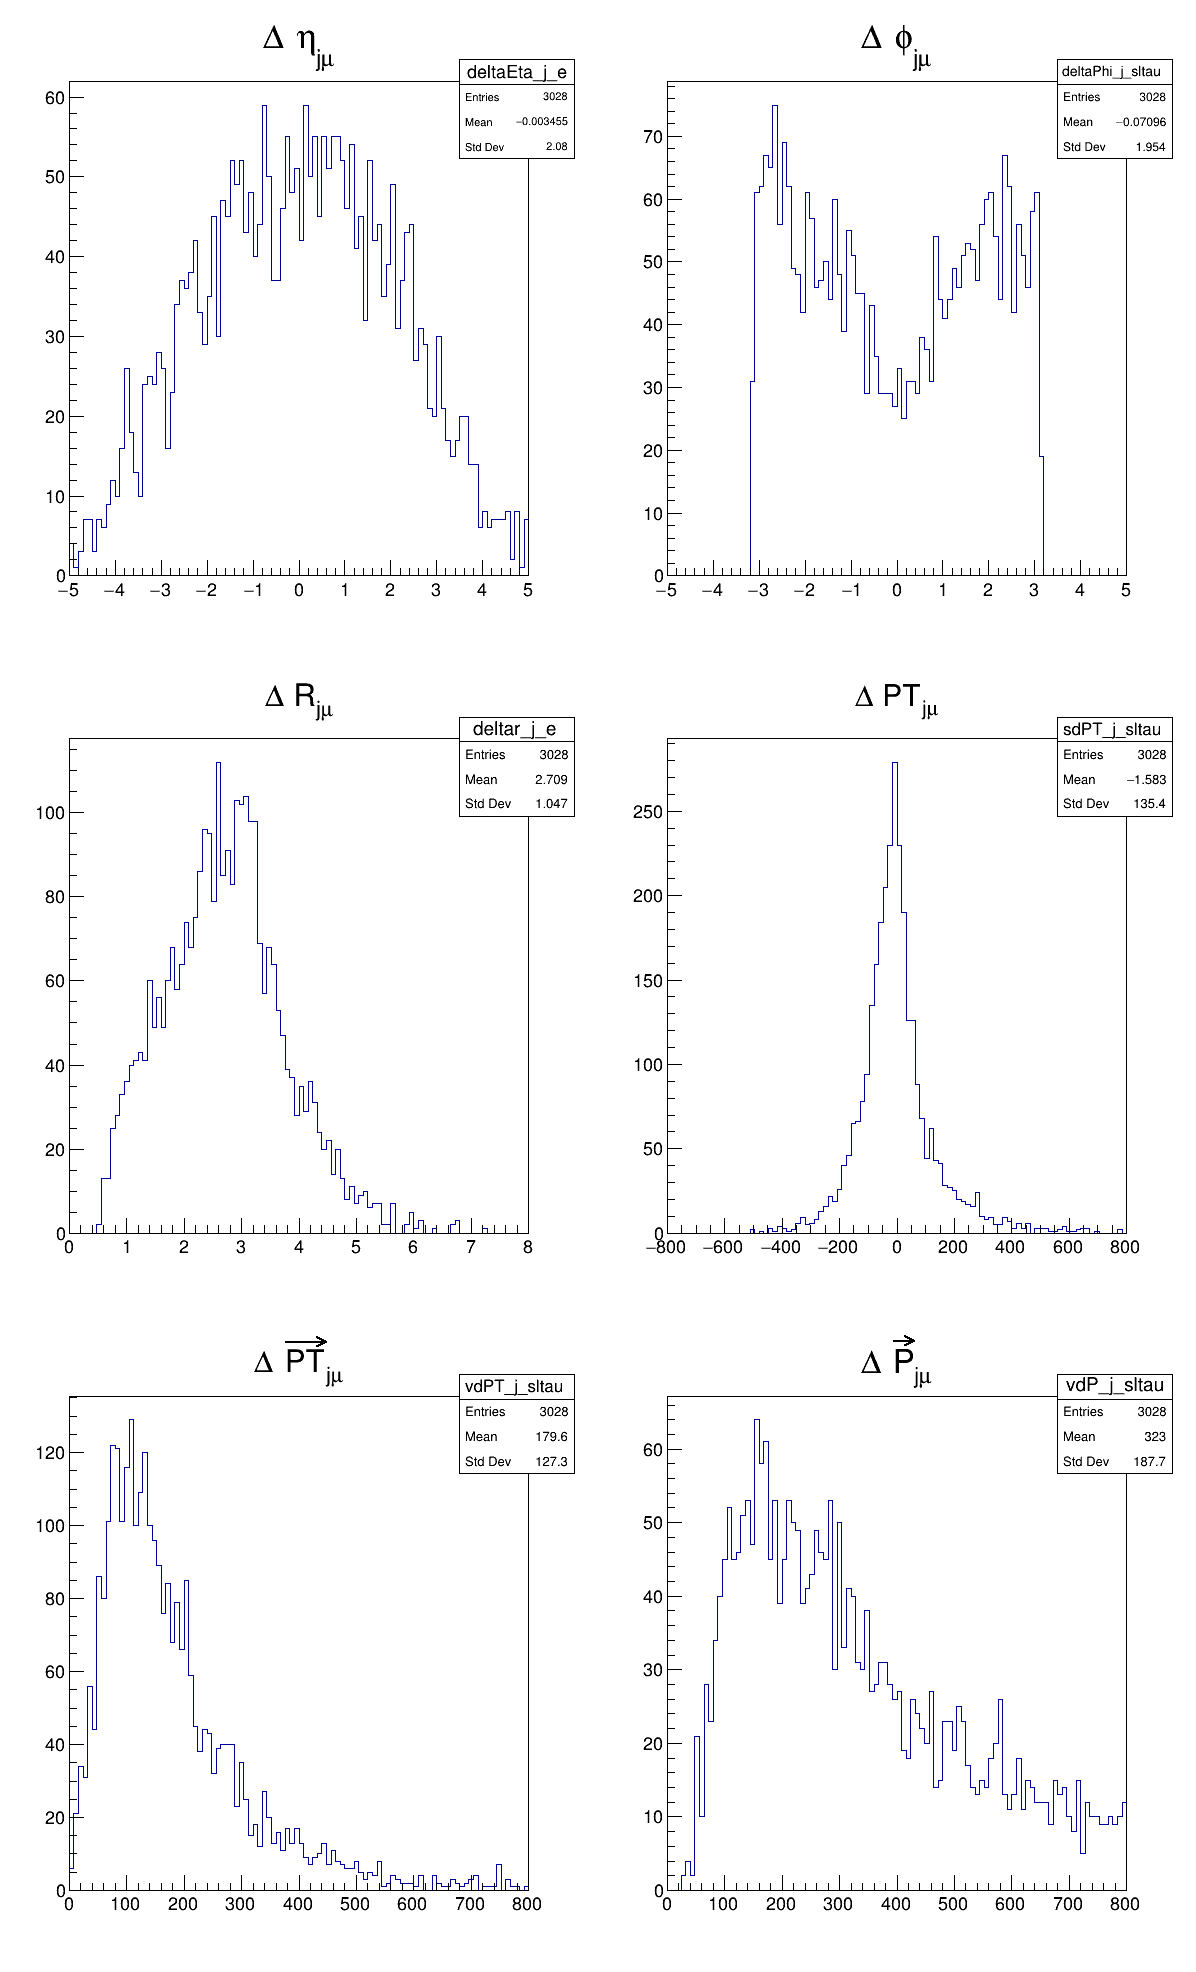

In [25]:
scanvas.cd(1)
hist_deltaEta_j_mu.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_j_mu.Draw("hist")
scanvas.cd(3)
hist_deltar_j_mu.Draw("hist")
scanvas.cd(4)
hist_sdPT_j_mu.Draw("hist")
scanvas.cd(5)
hist_vdPT_j_mu.Draw("hist")
scanvas.cd(6)
hist_vdP_j_mu.Draw("hist")
scanvas.Draw()

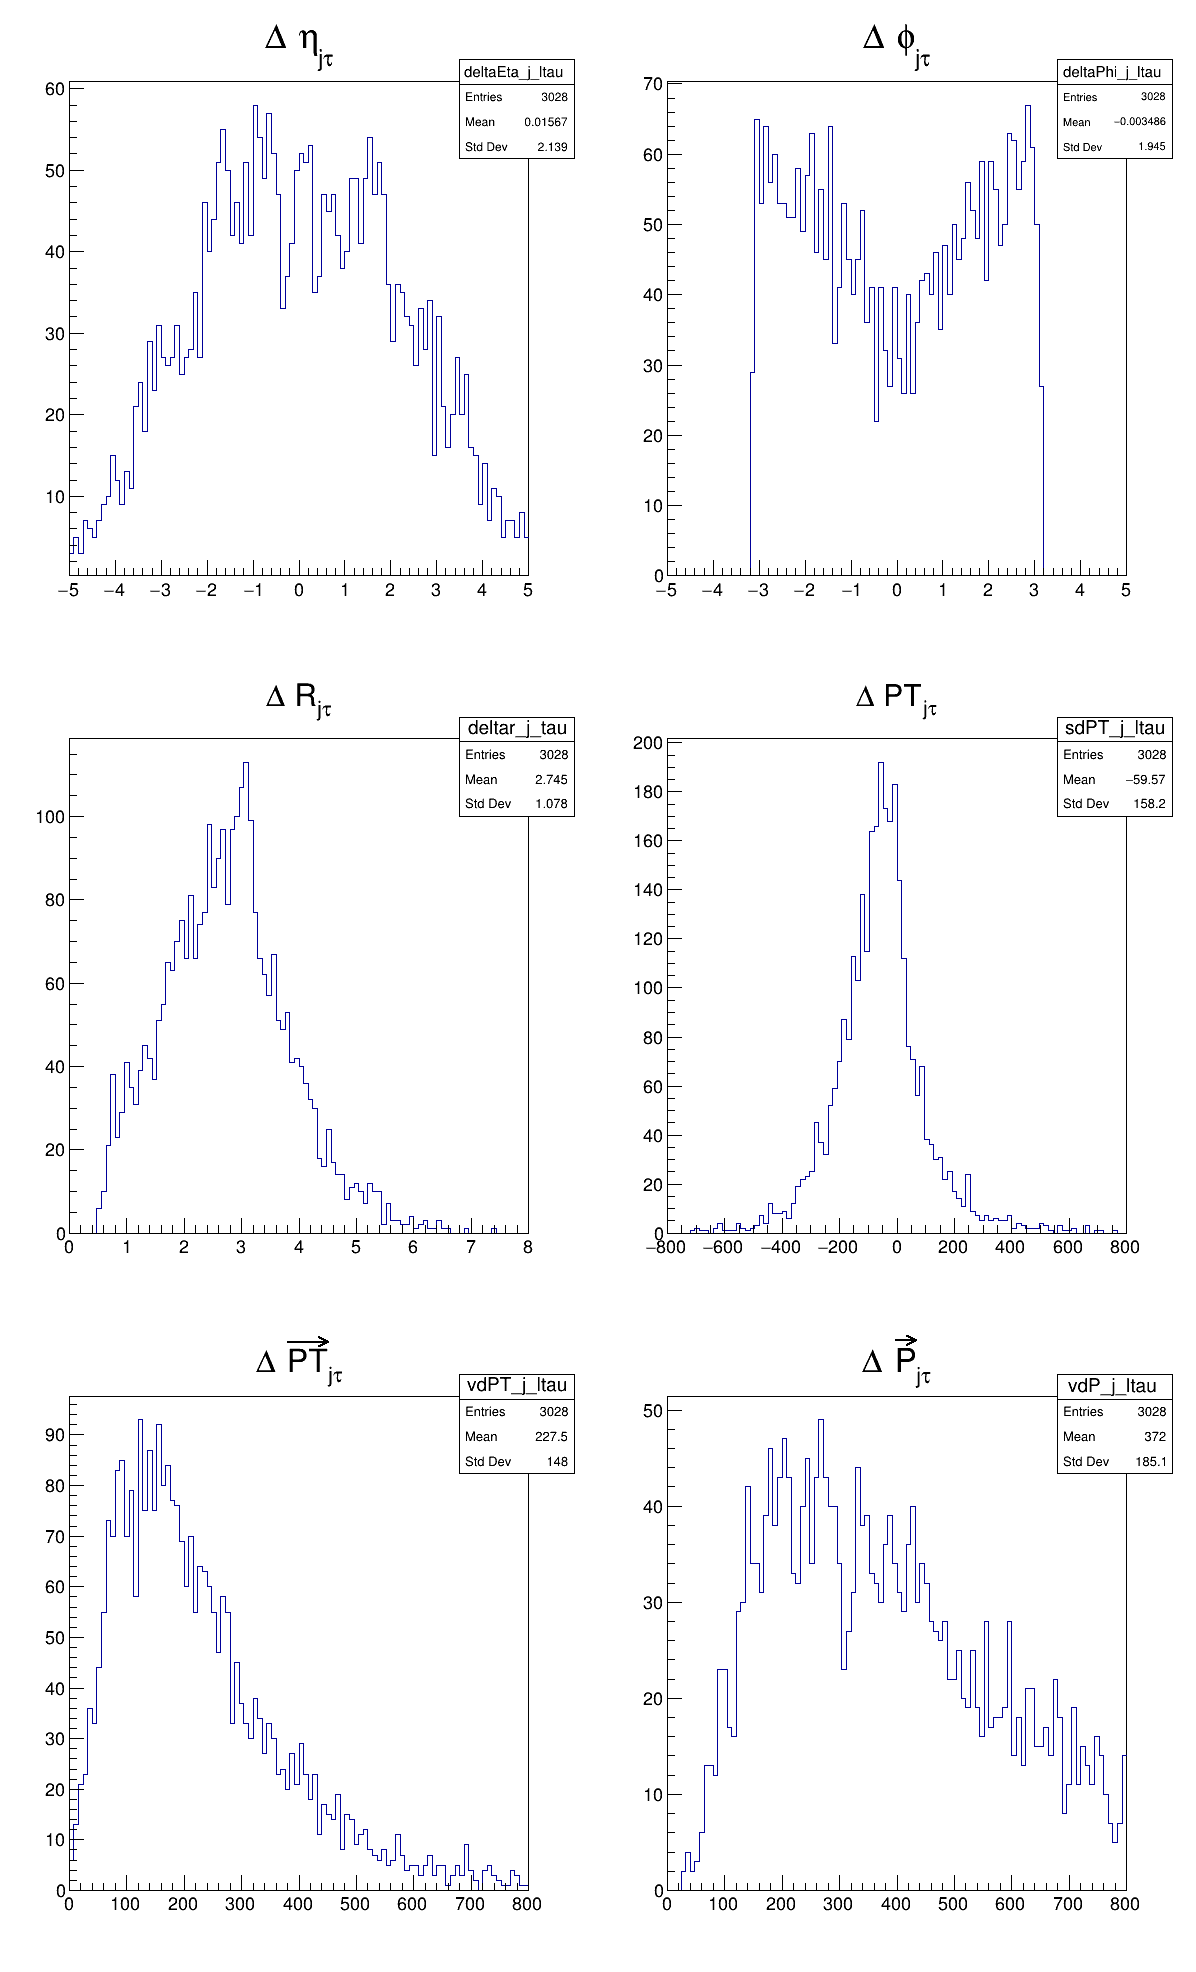

In [26]:
scanvas.cd(1)
hist_deltaEta_j_tau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_j_tau.Draw("hist")
scanvas.cd(3)
hist_deltar_j_tau.Draw("hist")
scanvas.cd(4)
hist_sdPT_j_tau.Draw("hist")
scanvas.cd(5)
hist_vdPT_j_tau.Draw("hist")
scanvas.cd(6)
hist_vdP_j_tau.Draw("hist")
scanvas.Draw()

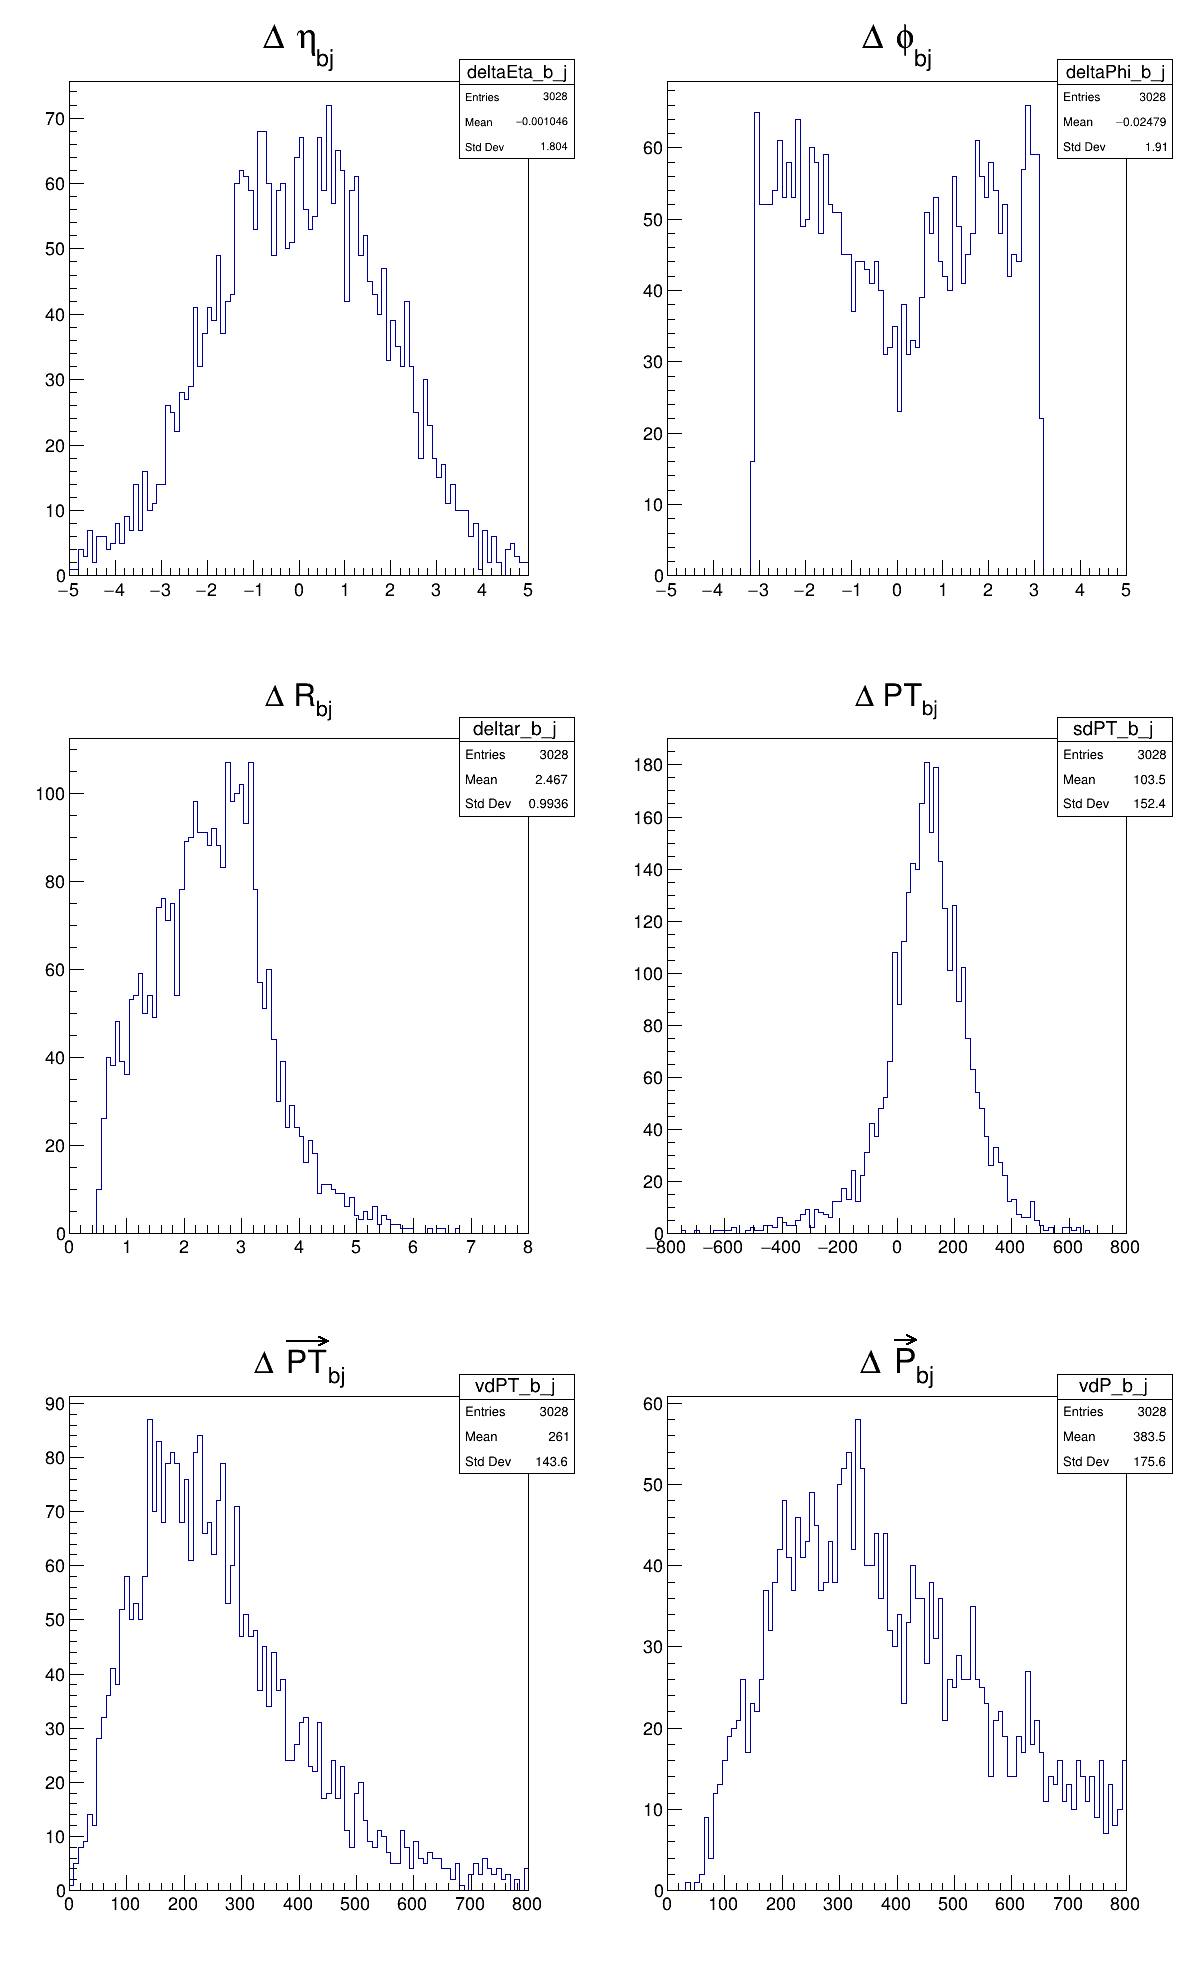

In [27]:
scanvas.cd(1)
hist_deltaEta_b_j.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_j.Draw("hist")
scanvas.cd(3)
hist_deltar_b_j.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_j.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_j.Draw("hist")
scanvas.cd(6)
hist_vdP_b_j.Draw("hist")
scanvas.Draw()

In [28]:
def writehistlist(name):
    l = TList()
    l.Add(cutflow)
    l.Add(hist_njets)
    l.Add(hist_m_LQ)
    l.Add(hist_pt_LQ)
    l.Add(hist_m_LQ_met)
    l.Add(hist_pt_LQ_met)
    l.Add(hist_met)
    l.Add(pt_all_jets)
    l.Add(eta_all_jets)
    l.Add(pt_lead_jets)
    l.Add(eta_lead_jets)
    l.Add(pt_lead_bjets)
    l.Add(eta_lead_bjets)
    l.Add(pt_taus)
    l.Add(eta_taus)
    l.Add(pt_muon)
    l.Add(eta_muon)


    l.Add(hist_deltar_tau_mu)
    l.Add(hist_deltar_b_tau)
    l.Add(hist_deltar_b_mu)
    l.Add(hist_deltar_j_tau)
    l.Add(hist_deltar_j_mu)
    l.Add(hist_deltar_b_j)

    l.Add(hist_deltaEta_tau_mu)
    l.Add(hist_deltaEta_b_tau)
    l.Add(hist_deltaEta_b_mu)
    l.Add(hist_deltaEta_j_tau)
    l.Add(hist_deltaEta_j_mu)
    l.Add(hist_deltaEta_b_j)


    l.Add(hist_deltaPhi_tau_mu)
    l.Add(hist_deltaPhi_b_tau)
    l.Add(hist_deltaPhi_b_mu)
    l.Add(hist_deltaPhi_j_tau)
    l.Add(hist_deltaPhi_j_mu)
    l.Add(hist_deltaPhi_b_j)

    l.Add(hist_sdPT_tau_mu)
    l.Add(hist_sdPT_b_tau)
    l.Add(hist_sdPT_b_mu)
    l.Add(hist_sdPT_j_tau)
    l.Add(hist_sdPT_j_mu)
    l.Add(hist_sdPT_b_j)

    l.Add(hist_vdPT_tau_mu)
    l.Add(hist_vdPT_b_tau)
    l.Add(hist_vdPT_b_mu)
    l.Add(hist_vdPT_j_tau)
    l.Add(hist_vdPT_j_mu)
    l.Add(hist_vdPT_b_j)

    l.Add(hist_vdP_tau_mu)
    l.Add(hist_vdP_b_tau)
    l.Add(hist_vdP_b_mu)
    l.Add(hist_vdP_j_tau)
    l.Add(hist_vdP_j_mu)
    l.Add(hist_vdP_b_j)

    l.Add(pt_forward_jets)
    l.Add(pt_central_jets)
    
    f =TFile(name+".root","RECREATE")
    l.Write("histlist", TObject.kSingleKey)
    f.ls()

In [29]:
writehistlist('SingleLQ_500_SemiLeptonic_mu_hadronic')

TFile**		SingleLQ_500_SemiLeptonic_mu_hadronic.root	
 TFile*		SingleLQ_500_SemiLeptonic_mu_hadronic.root	
  KEY: TList	histlist;1	Doubly linked list
